## Creation of all files for 10 GeV Dark Matter Partice, detection Using FERMI LAT

Let's start. First we read from the file created using the PYTHIA simulation the columns corresponding to mass of the dark matter particle, $M_{dm}$, the quantities $\log_{10}x$ and $dN/d\log_{10} x$, where $x \equiv E/M_{dm}$ of the produced photons via the $b\bar{b}$ channel. We select and create arrays of the "energy" ($\log_{10}x$) and "spectrum" ($dN\log_{10} x$) of photons corresponding to the the selected Dark Matter mass (in GeV). We select 10 GeV in this case.

### Part A: Binning and events number counting

In [1]:
import numpy as np
import scipy.integrate as integrate
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 
from astropy.io import fits

#We open and read the file containing the spectrum. The file should be at the same directory as our script/notebook
mass, energ, bibibar = np.loadtxt("AtProduction_gammas.dat", usecols=(0,1,13), unpack=3)


#since we don't know the size of the file, let's find the length of the columns. Find the upper limit; 
#when then we are going to run a for loop, we will know the range
a = np.shape(mass)
uplim=a[0]-1

#Choose the mass of the Dark Matter particle; here 10GeV - units in the file are in GeV
mdm = 10.0

#Now, let us find how many entries have that value. We will need this number in a while.

size=0
for i in range (0,uplim):
    if (mass[i] == mdm):
        size +=1
        
#size is the number of entries corresponding to the specific value of mass. Let us create two arrays with zeros, of that size.
# The titles are logex and diendlogex, which are quite descriptive about what they contain (what they are going to contain).

logex = np.zeros(size)
diendlogex = np.zeros(size)

#Let's populate the arrays logex, diendlogex
# x=photon energy / dark matter particle mass

j = 0 
for i in range (0,uplim):
    if (mass[i] == mdm):
        logex[j] = energ[i]
        diendlogex[j] = bibibar[i]
        j +=1

In [2]:
#Remember, each array starts from zero. Useful to define the number size-1, call it n, which will serve as an upper limit

n = size -1

#just useful when we want to find the entry with the maximum index
#If we generally want to run a loop, limits 0,size are the approptiate 

Now: $\log_{10}x = \log_{10} \frac{E}{M_{dm}} = \log_{10} \frac{E}{GeV} \frac{GeV}{M_{dm}} \Rightarrow \log_{10} \frac{E}{GeV} = \log_{10}x + \log_{10} \frac{M_{dm}}{GeV} $. Since everything is expressed in GeV, is easy to create the array  
containing the logs of the energies:

In [3]:
logE = logex + np.log10(mdm) 
dNdlogE = diendlogex

#Now, let's get an idea of the range of energies we have.
#Print the lowest and maximum energies of photons.

print("minimum energy - in GeV:")
print(np.power(10,logE[0]))
print("maximum energy - in GeV:")
print(np.power(10,logE[n]))

minimum energy - in GeV:
1.25892541179e-08
maximum energy - in GeV:
10.0


We see that we get a pretty good range of energies. Of course we are interested in one more limited range of photon energies. 

We want to calculate the number of counts for a number of (logarithmic bins).

Denote $b = dN / d\log_{10} E$. Thus, in a bin :

\begin{equation}
N = time \times \int_{\log E_{low}}^{\log E_{up}} \frac{dN}{d\log E} A_{eff}(\log E)  d\log E
\end{equation}

Since we have to multiply by the total exposure time and also in the integration we have to take into account the $A_{eff}(E)$ (integrate over it). 

##### Note: in case of Fermi, we use Acceptance

In [4]:
#energies, bins from 0, size 


#Let's choose energies of photons. Remember energy is given in Gev

#Starting energy of photons in GeV 0.1 GeV for Fermi 

Est = 0.1


#Maximum energy = equal to the dark matter mass for Fermi
Eend = mdm


#Since we work in log space, let's define their logarithms

logstart = np.log10(Est)
logend = np.log10(Eend)

#Now, define the number length of logarithmic step. Let's take it equal to 1/5
#This is the inverse of the number of bins per decade

logstep = 1.0/5.0 

#Let's find the number of energy bins:

numbins = int((logend-logstart)/logstep)  

print(numbins)

#Create empty array, with number of entries equal to the number of bins, which we are going to populate

counts = np.zeros(numbins)


# We will also need the Acceptance for FermiLat
#In the following Aenerg is the energy -warning it is given in Mev- and Aeff the acceptance in m^2*sr


Aenerg, Aeff = np.loadtxt("Acceptance_Fermi.dat", usecols=(0,1), unpack=3)


#Now the energy is given in MeV. We need to convert this in GeV and also we need actually its logarithm
#define logAenerg

logAenerg = np.log10(Aenerg/1000.0)

#Thus, Aeff is now function of the log of the energy 

# Aeff in m^2, let's convert in cm^2 by multiplying by 10000 in the case of Fermi
#Note: A_eff is actually acceptanceGAM

Aeff = Aeff*10000
print(Aeff)


#Let's now use interpolation in order to have a value corresponding to dN/dlogE for every
#Also a interpolation in order to get a value for every energy for Aeff

from scipy import interpolate

intrpdNdlogE = interpolate.interp1d(logE, dNdlogE)
intrpAeff = interpolate.interp1d(logAenerg, Aeff)


#Function which implements a trapezoidal rule integration
#For the integrated function, see above 

def integralino(a,b):
    #Number of points
    nu = 1000
    #step 
    h = (b - a)/nu
    summa = 0.0
    for j in range (0,nu):
        x1 = a + j*h
        x2 = x1 + h
        q1 = (intrpdNdlogE(x1))*(intrpAeff(x1))
        q2 = (intrpdNdlogE(x2))*(intrpAeff(x2))
        summa = summa +  q1 + q2
    summa = summa*h/2.0
    return summa


#So, we now have an array with as many cells as the number of energy bins. Let's populate them.
# We will also need total exposure time

#Years 7 for fermi

years=7.0



# frac_years 1/4pi for Fermi. This is actually for acceptance 



frac_year = 1.0/(4.0*np.pi)


sec_year = 365*24*3600 

#exposure time

texp = years*frac_year*sec_year


 

#We have also to introduce a normalization factor

norm = 2.87e-10/2.0


#In the case of 10 GeV dark matter I also include a relative normalization factor

relnorm = 1.67383318364

 

for i in range (0,numbins):
    ll = logstart + i*logstep         #upper limit of the energy bin
    ul = logstart + (i+1)*logstep     #lower limit of the energy bin
    if (ul > logend):                 #special case, accounts for the last cell
        ul = logend
    counts[i] = relnorm*norm*texp*integralino(ll, ul)

# Erase the comment symbol in order to see the number of counts
print(counts)



10
[    49.22386639    211.72924834   1167.07380634   3285.19114415
   6777.96913594  11539.46384464  15560.87380181  19212.24138322
  22440.70339233  24823.35425684  25091.36848784  24302.22756011
  24570.45933513  24415.56799384  25053.6246006   25374.61080015
  25219.82823087  25065.04566158  25015.98948537  24332.4661787
  21851.81173378  16833.61508305  10916.74409119]
[  1.04940472e+02   1.47782199e+02   1.71557088e+02   1.58635655e+02
   1.13629254e+02   5.96938556e+01   2.21578002e+01   5.48548620e+00
   8.03942670e-01   4.92714355e-02]


### Part B: Creation of all Files 

Here we create all files, for all models we consider, in the case of 10GeV dark matter particle and detection using FERMI.

These models are:

###### One central point source

###### Central Extended source, 2D Gaussian profile, $\theta_{68} = 0.25^o$ (degrees)

###### Central Extended source, truncated NFW profile (actually $1/r$) , again $\theta_{68} = 0.25^o$ (degrees)

###### Two point sources, angular distance $0.32^o$  (degrees). Configuration centered around the position of J2212.5+0703

###### Two point sources, angular distance $0.50^o$ (degrees). Configuration centered around the position of J2212.5+0703

###### Two point sources - non cocentric model. One point source at the center (at the position of J2212.5+0703) and one at J221251+064604
###### (this is the best fit solution mentioned in Hooper et al)


Let's give the coordinates of three sources we are going to need. First of all of the source mentioned in Hooper et. al. paper as a Dark Matter subhalo candidate, $J2212.5+0703$, as well as the two nearby sources, $J221251+064604$ and $J221408+071128$.

$\qquad$ $\qquad$ $\qquad$ $\qquad$ $l$ $\qquad$ $\qquad$ $\,\,\,\,\,\,\,\,\,b$

J2212.5+0703:  $\qquad$     $\,\,\,\,\, 68.7423^o$  $\qquad$     $\,\,\,\,\,-38.5648^o$   

J221251+064604:  $\qquad$     $68.52764^o$  $\qquad$     $-38.81095^o$  

J221408+071128:  $\qquad$     $69.20910^o$  $\qquad$     $-38.75225^o$  


We will start by defining the grid and the central point.

Always the grid is $20^o \times 20^o$ (in our case 400 x 400 pixels, thus bin length $0.05^o$ degrees).  It is centered around the source $J2212.5+0703$.

So, in the following line we define the center and the boundaries of the grid/patch of the sky we consider. We will also define the bin length here.



In [5]:
# Define the coordinates of the center of the grid
#latitude and longitue in galactic coordinates 
#longitude in l, latitude in b
# longitude is the x-like coordinate, latitude is the y-like coordinate

#the center is at the position of source J2212.5+0703

centerl = 68.7423
centerb = - 38.5648

#Having the position of the center, we can define the limits in x and y. Remember, the grid is defined as +/- 10 degrees 
#from the center

#First, let's make a choice for the coordinates of the upper left point 
#We define it to be 10 degrees of in each direction 

upx = centerl + 10.0 
upy = centerb + 10.0

#Now, find the other limits

lowx = upx - 20.0
lowy = upy - 20.0

#------------------------------------------------------------------
#------------------------------------------------------------------

# define angular length of each "pixel" of the grid

binlen = 0.05 #in degrees

#we want a 20*20 degrees box, define its size 

leng = int(20.0/binlen)

#------------------------------------------------------------------
#------------------------------------------------------------------

# Now, define two very very useful functions that take as input the coordinates of the  sources and return 
# the pixel positions of them


def pixelposx(x,ux,binln):
    posx = int((ux - x)/binln)
    return posx


def pixelposy(y,uy,binln):
    posy = int((uy - y)/binln)
    return posy

#### Model 1 : One Central Source 

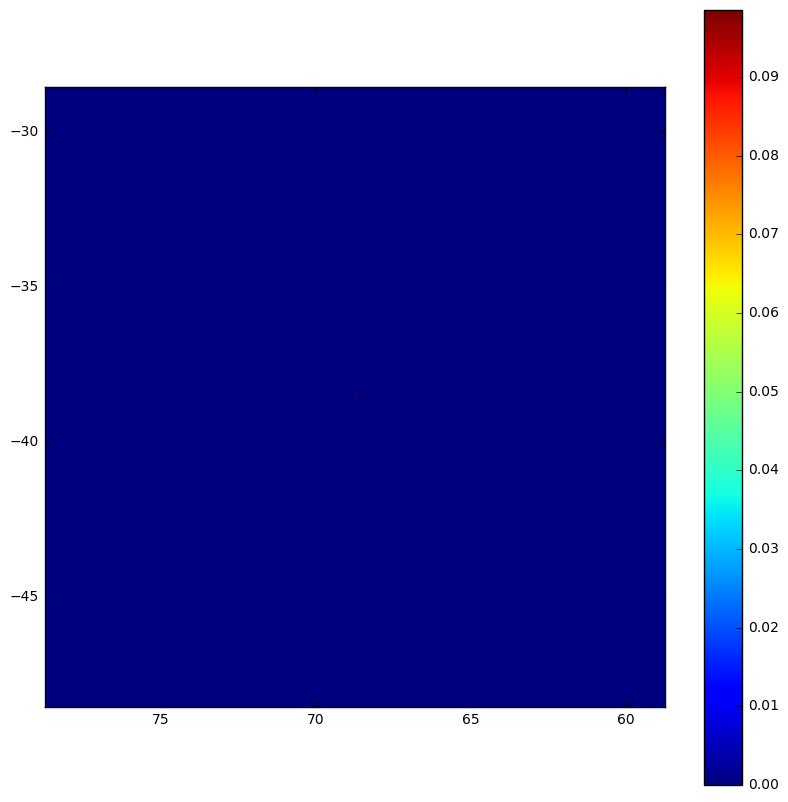

In [6]:
# Create empty array to be populated

onesource = np.zeros((numbins,leng,leng))

# position of the source
# position is at the center of the grid; at the coordinates of J2212.5+0703

sourcel = 68.7423
sourceb = -38.5648

# find  pixel position

pospixx = pixelposx(sourcel,upx,binlen) 
pospixy = pixelposy(sourceb,upy,binlen)

#Ready to populate the array
#multiply counts by 2, since we have only one source

for i in range (0,numbins):
    onesource[i][pospixy][pospixx] = 2.0*counts[i]
    

hdu = fits.PrimaryHDU()
hdu.data = onesource

hdu.writeto('10GeV_Fermi_CentralPointSource.fits', clobber = True)

fig=plt.figure(figsize=(10.0, 10.0))
plt.imshow(hdu.data[9], extent=[upx,lowx,lowy,upy])
plt.autoscale(False)
plt.xlim(upx,lowx)
plt.ylim(lowy,upy)

plt.colorbar()    

#### Model 2 : Central Extended Source: 2D Gaussian extension

Next we consider the following model: Extended source at the center of the grid, gaussian distribution of counts:
\begin{equation}
N \sim e^{-\frac{1}{2}\frac{x^2+y^2}{\sigma^2}}
\end{equation}
with  $\sigma = 0.16725^\circ$. That way, $68%$ of the light is inside angle $0.25^o$

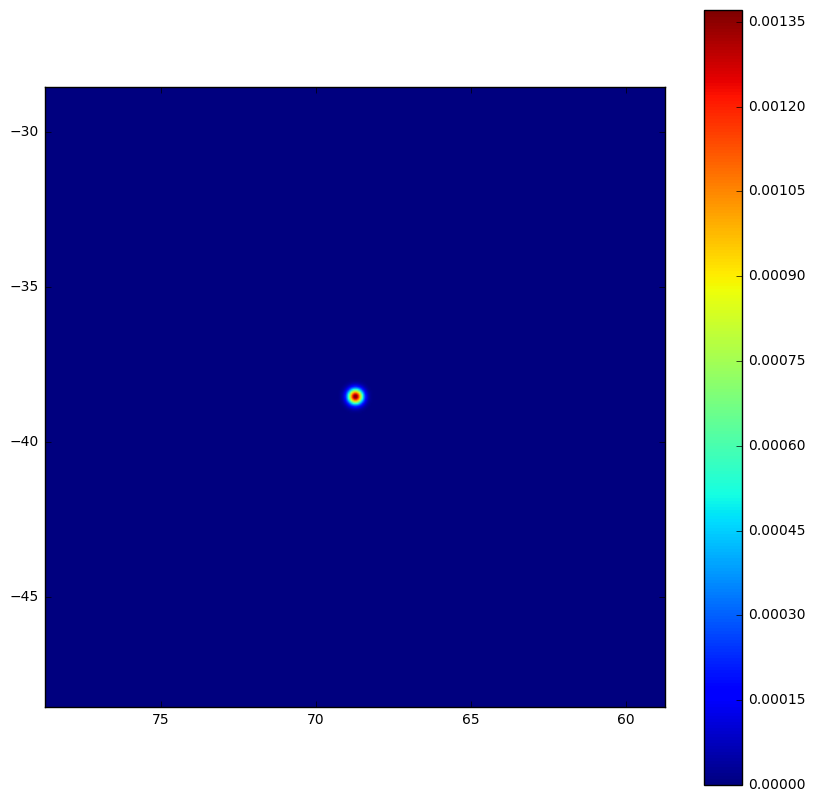

In [7]:
#create again an empty 3d array - a 20x20 degrees box 

extsource = np.zeros((numbins,leng,leng))

#define std deviation 

sigma = 0.16725 

#The array is a 400*400 arrray - it has no central point. Instead we will define four central points 
#define the coordinates of the four four central points. Define the points as lr = low right, ll = low left, ur = upper right
#ul = upper left. A simple diagram would be very helpful here. 
#i is row, j is column

adef = int(leng/2.0)



lri = adef; lrj = adef
lli = adef; llj = adef - 1
uri = adef - 1; urj = adef
uli = adef -1; ulj = adef - 1

#the following function finds the quarter of the grid 
# named again ll, lr, ur, ul  


def quarter(i,j):
    if ((i >= lri) and (j >= lrj)):
        quarto = "lr"
    elif ((i >= lli) and (j <= llj)):
        quarto = "ll"
    elif ((i <= uri) and (j >= urj)):
        quarto = "ur"
    elif ((i <= uli) and (j <= ulj)):
        quarto = "ul"
    return quarto


#the following function calculates and returns the value as calculated from a 2d gaussian distribution 

def gaussian(a,b,i,j):
    forx = abs(j - b)*binlen + (binlen/2.0)
    fory = abs(i - a)*binlen + (binlen/2.0)
    exponent = - (forx**2.0 + fory**2.0)/(2.0*(sigma**2.0))
    value = np.exp(exponent)
    return value 

#populate the array
#energies will run in k 
#keep track of the total value of entries in each slice in order to normalize 

norma = 0.0
for k in range (0,numbins):
    for i in range (0, leng):
        for j in range (0, leng):
            quar = quarter(i,j)
            if (quar == "lr"):
                entry = gaussian(lri,lrj,i,j)
            elif (quar == "ll"):
                entry = gaussian(lli,llj,i,j)
            elif (quar == "ur" ):
                entry = gaussian(uri,urj,i,j)
            elif (quar == "ul"):
                entry = gaussian(uli,ulj,i,j)
            extsource[k][i][j]= entry
            if (k == 0):
                norma = norma + entry 
                
                
#Normalize now the array and multiply by the number of counts per energy bin - here multiply by 2.0 because we 

for k in range (0, numbins):
    extsource[k] = (2.0*counts[k])*extsource[k]/norma


hdu1 = fits.PrimaryHDU()
hdu1.data=extsource

hdu1.writeto('10GeV_Fermi_GaussExtended.fits', clobber = True)

fig=plt.figure(figsize=(10.0, 10.0))
plt.imshow(hdu1.data[9], extent=[upx,lowx,lowy,upy])
plt.autoscale(False)
plt.xlim(upx,lowx)
plt.ylim(lowy,upy)

plt.colorbar()    
    

#### Model 3 :  Central Extended source: Truncated NFW extension

Using DM density profile $\rho(r) \propto \frac{1}{r}$.

$\theta_{max} = 0.0084$ rad is the critical angle , such that $68\%$ of the light is inside $0.25^o$.

//anaconda/lib/python3.5/site-packages/scipy/integrate/quadpack.py:356: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)


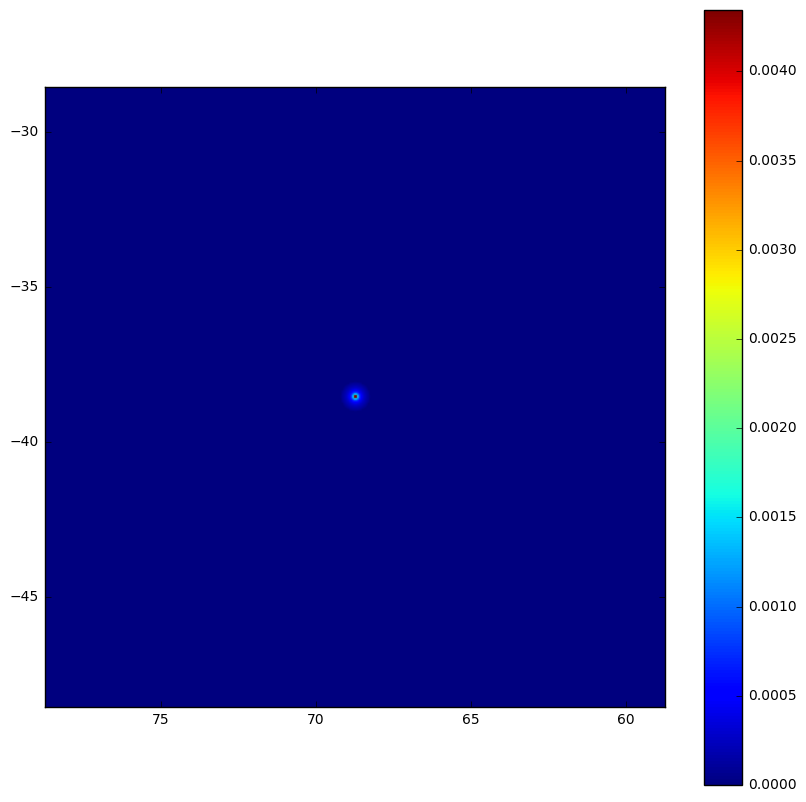

In [8]:
# Degree to rad and rad to degree conversions

degrad = 0.0174533 #degrees to rads
raddeg = 57.29575 #rads to degrees

#-------------------------------------------------

# Now define a sigma, the sigma you want in DEGREES
sigma = 0.25
# Contvert this to rad
sigma = sigma*degrad

#Define the theta_max we found
#in rad

thet_max = 0.00841379

#------------------------------------------------

#Size of grid and bin length

binlen = 0.05 #in deg
binlen = binlen*degrad #in rads

N = 400

#Create the grid 

grid = np.zeros((numbins,N,N))

#-----------------------------------------------------------------------------------------------
# Here I define function that takes as input the position of the origin a,b, the position of the bin or the subbin and the subbin
# length - since it changes - and returns the value of j in the subbin. also the value of the 

def integrand(u, thet):
    integr = 1.0/(1.0 + u**2.0 - 2.0*u*np.cos(thet))
    return integr


def J_value(ori,orj,i,j, length):
    'ori,orj are the coordinates of the origin i,j those of the bin and len the size of each bin'
    
    distx = (abs(j - orj) + 0.5)*length
    disty = (abs(i - ori) + 0.5)*length
    #calculate distance in theta
    
    thet = np.sqrt(distx**2.0 + disty**2.0)
    if (thet < thet_max):
        #limits of integration
        alow = 1.0 - thet_max*np.sqrt(1.0 - (thet/thet_max)**2.0)
        aup = 1.0 + thet_max*np.sqrt(1.0 - (thet/thet_max)**2.0)
        integroulino = integrate.quad(integrand, alow, aup, args=(thet))[0]
    else:
        integroulino = 0.0
    return integroulino

#-------------------------------------------------------------------
#The array  we have created is a 400*400 arrray - it has no central point. Instead we will define four central points 
#define the coordinates of the four four central points. Define the points as lr = low right, ll = low left, ur = upper right
#ul = upper left. A simple diagram would be very helpful here. 
#i is row, j is column

adef = int(N/2)

lri = adef; lrj = adef
lli = adef; llj = adef - 1
uri = adef - 1; urj = adef
uli = adef -1; ulj = adef - 1

##the following function finds the quarter of the grid 
# named again ll, lr, ur, ul  


def quarter(i,j):
    if ((i >= lri) and (j >= lrj)):
        quarto = "lr"
    elif ((i >= lli) and (j <= llj)):
        quarto = "ll"
    elif ((i <= uri) and (j >= urj)):
        quarto = "ur"
    elif ((i <= uli) and (j <= ulj)):
        quarto = "ul"
    return quarto
#---------------------------------------------------------------
#---------------------------------------------------------------
# This is the main body of the program, it 
# calculates  J_theta  
# inside the gid and returns them
# We will need also one more function in case we deal with one of the central sources



def subbin(length):
    'This function calculates and returns the mean value of J for the four central points. the value is the same for all'
    
    #number of subbins of teh subgrid
    numb = 50
    #length of subbins
    subleng = length/numb
    
    subgrid = np.zeros((numb,numb))
    
    #coordinates of the origin
    origi = numb - 1
    origj = 0
    
    for i in range (0,numb):
        for j in range (0,numb):
            subgrid[i][j] = J_value(origi,origj,i,j,subleng)
    
    sub_val = np.average(subgrid)
    return sub_val


subbin_val = subbin(binlen)

for k in range (0,numbins):
    for i in range (0,N):
        for j in range (0,N):
            quar = quarter(i,j)
            if (quar == "lr"):
                if ((i == lri)and(j == lrj)):
                    entry = subbin_val
                else:
                    entry = J_value(lri,lrj,i,j,binlen)
                
            elif (quar == "ll"):
                if ((i == lli)and(j == llj)):
                    entry = subbin_val
                else:
                    entry = J_value(lli,llj,i,j,binlen)
                    
            elif (quar == "ur" ):
                if ((i == uri)and(j == urj)):
                    entry = subbin_val
                else:
                    entry = J_value(uri,urj,i,j,binlen)
                    
            elif (quar == "ul"):
                if ((i == uli)and(j == ulj)):
                    entry = subbin_val
                else:
                    entry = J_value(uli,ulj,i,j,binlen)
            
            grid[k][i][j] = entry

#normalization factor

norma = np.sum(grid[0][:][:])

#Multiply

for k in range (0, numbins):
    grid[k] = (2.0*counts[k])*grid[k]/norma
    
#Define again binlen in degrees -- we will need this later

binlen = 0.05 #in degrees

hdu2 = fits.PrimaryHDU()
hdu2.data=grid

hdu2.writeto('10GeV_Fermi_NFWextended.fits', clobber = True)

fig=plt.figure(figsize=(10.0, 10.0))
plt.imshow(hdu2.data[9], extent=[upx,lowx,lowy,upy])
plt.autoscale(False)
plt.xlim(upx,lowx)
plt.ylim(lowy,upy)

plt.colorbar()

#### Model 4 : Two sources - constant separation 0.32 degrees. Centered at the position of J2212.5+0703

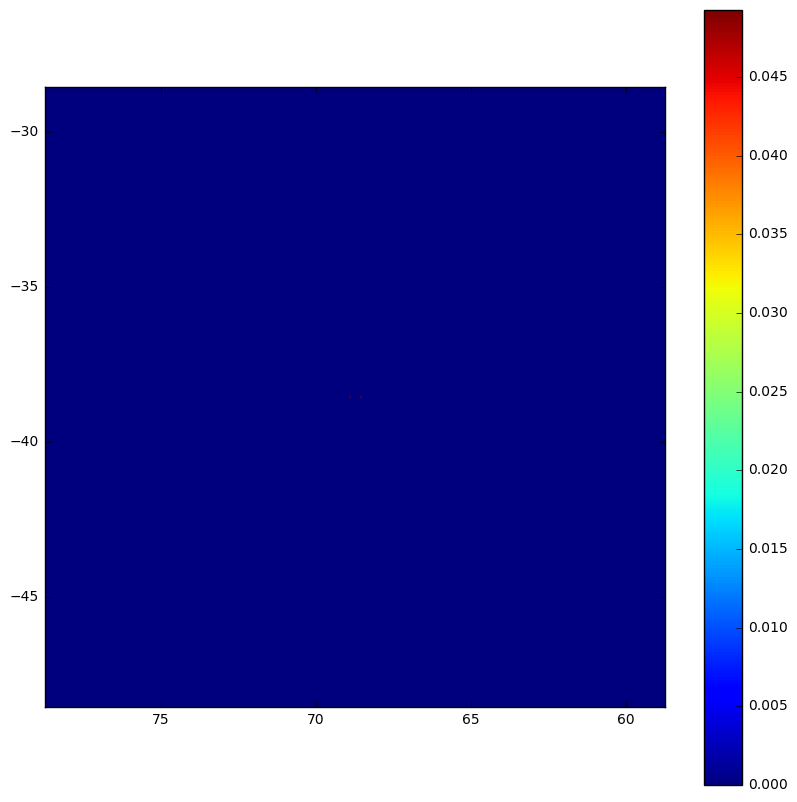

In [9]:
#create 3d array, with the appropriate angular size and number of bins corresponding to the energy bins

twosources032 = np.zeros((numbins,leng,leng))

#Define the coordinates of the two sources. These are in the middle y -scale and a distance 0.32 degrees from the middle point in the x direction
#First, let's state the coordinates of the two sources, latitde and longitude
#in galactic coordinates
#longitude in l, latitude in b
# longitude is the x-like coordinate, latitude is the y-like coordinate



source1l = upx - 10.0 - 0.16
source1b = upy - 10.0

source2l = upx - 10.0 + 0.16
source2b = upy - 10.0

pospix1x_032 = pixelposx(source1l,upx,binlen) 
pospix1y_032 = pixelposy(source1b,upy,binlen)
pospix2x_032 = pixelposx(source2l,upx,binlen) 
pospix2y_032 = pixelposy(source2b,upy,binlen)

#Ready to populate the array

for i in range (0,numbins):
    twosources032[i][pospix1y_032][pospix1x_032] = counts[i]
    twosources032[i][pospix2y_032][pospix2x_032] = counts[i]
    
    
hdu3 = fits.PrimaryHDU()
hdu3.data=twosources032

hdu3.writeto('10GeV_Fermi_TwoSources_032separation.fits', clobber = True)

fig=plt.figure(figsize=(10.0, 10.0))
plt.imshow(hdu3.data[9], extent=[upx,lowx,lowy,upy])
plt.autoscale(False)
plt.xlim(upx,lowx)
plt.ylim(lowy,upy)

plt.colorbar()



#### Model 5 : Two sources - constant separation 0.50 degrees. Centered at the position of J2212.5+0703

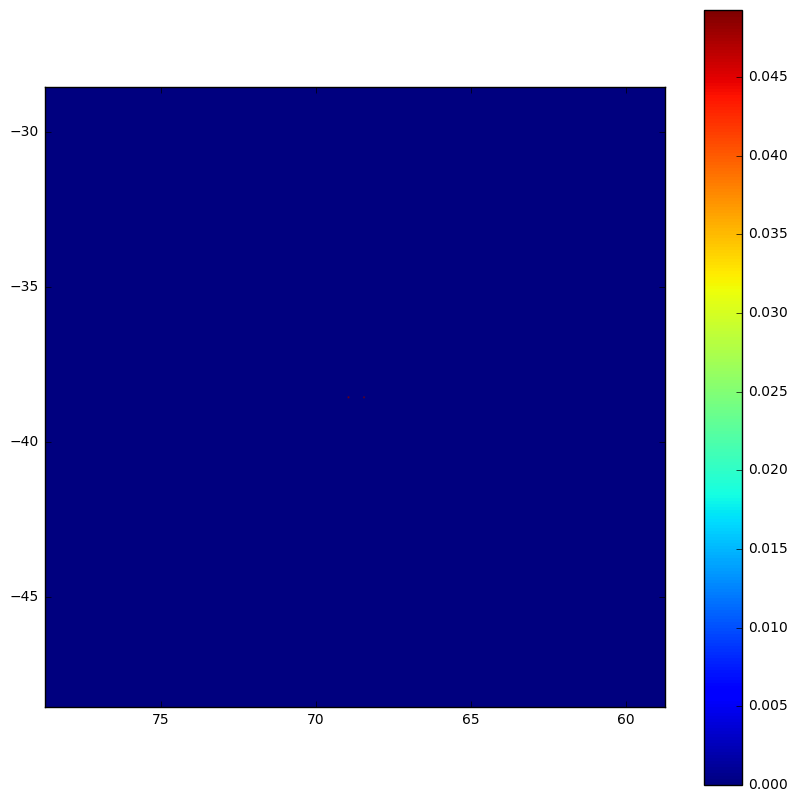

In [10]:
#create 3d array, with the appropriate angular size and number of bins corresponding to the energy bins

twosources050 = np.zeros((numbins,leng,leng))

#Define the coordinates of the two sources. These are in the middle y -scale and a distance 0.5 degrees from the middle point in the x direction
#First, let's state the coordinates of the two sources, latitde and longitude
#in galactic coordinates
#longitude in l, latitude in b
# longitude is the x-like coordinate, latitude is the y-like coordinate



source1l = upx - 10.0 - 0.25
source1b = upy - 10.0

source2l = upx - 10.0 + 0.25
source2b = upy - 10.0

pospix1x_050 = pixelposx(source1l,upx,binlen) 
pospix1y_050 = pixelposy(source1b,upy,binlen)
pospix2x_050 = pixelposx(source2l,upx,binlen) 
pospix2y_050 = pixelposy(source2b,upy,binlen)

#Ready to populate the array

for i in range (0,numbins):
    twosources050[i][pospix1y_050][pospix1x_050] = counts[i]
    twosources050[i][pospix2y_050][pospix2x_050] = counts[i]
    
    
hdu4 = fits.PrimaryHDU()
hdu4.data=twosources050

hdu4.writeto('10GeV_Fermi_TwoSources_050separation.fits', clobber = True)

fig=plt.figure(figsize=(10.0, 10.0))
plt.imshow(hdu4.data[9], extent=[upx,lowx,lowy,upy])
plt.autoscale(False)
plt.xlim(upx,lowx)
plt.ylim(lowy,upy)

plt.colorbar()

#### Model 6 : No-cocentric distribution of sources.  Sources J2212.5+0703 and J221251+064604

In the paper of Hooper et. al. it is mentioned that: 

"The best fit found in this exercise was for a point source at the location of BZQ J2212+0646/CRATES J221251+064604 and a second point source at or near the location of 3FGL J2212.5+0703"

Here, we consider that model as well

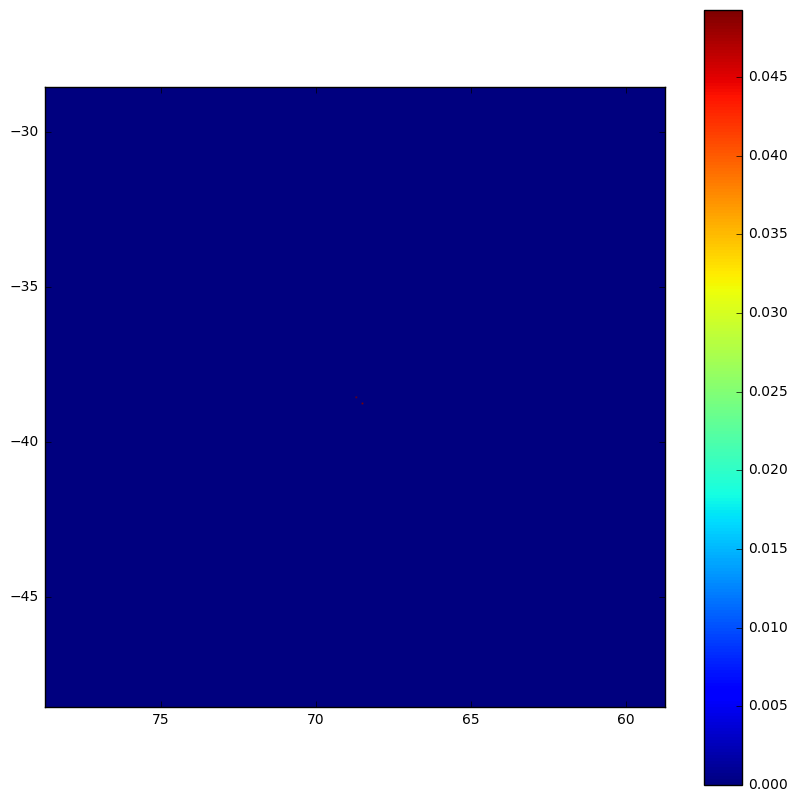

In [11]:
#create 3d array, with the appropriate angular size and number of bins corresponding to the energy bins

twosources_bf = np.zeros((numbins,leng,leng))

#define the coordinates of the two sources
#Source 1 is the  J2212.5+0703
#Source 2 is the J221251+064604

source1l = 68.7423
source1b = -38.5648

source2l = 68.52764 
source2b = -38.81095

pospix1x_bf = pixelposx(source1l,upx,binlen) 
pospix1y_bf = pixelposy(source1b,upy,binlen)
pospix2x_bf = pixelposx(source2l,upx,binlen) 
pospix2y_bf = pixelposy(source2b,upy,binlen)

#Ready to populate the array

for i in range (0,numbins):
    twosources_bf[i][pospix1y_bf][pospix1x_bf] = counts[i]
    twosources_bf[i][pospix2y_bf][pospix2x_bf] = counts[i]
    
hdu5 = fits.PrimaryHDU()
hdu5.data=twosources_bf

hdu5.writeto('10GeV_Fermi_TwoSources_BestFit.fits', clobber = True)

fig=plt.figure(figsize=(10.0, 10.0))
plt.imshow(hdu5.data[9], extent=[upx,lowx,lowy,upy])
plt.autoscale(False)
plt.xlim(upx,lowx)
plt.ylim(lowy,upy)

plt.colorbar()    

